## Proyecciones de Natalidad en Jalisco (Python)

El objetivo de este proyecto, es predecir la natalidad en el Estado de Jalisco para los años 2019 al 2021, utilizando los datos anuales del 2010 al 2018. Así como ofrecer una evaluación de los resultados.

In [193]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3

In [194]:
con: sqlite3.Connection = sqlite3.connect("file:./data/natalidad_en_mexico.sqlite?mode=ro", uri=True)
df_nacimientos: pd.DataFrame = pd.read_sql_query("SELECT * from nacimientos", con)

display(df_nacimientos.head())

con.close()

,Estado,Total,Hombres,Mujeres,No Especificado,Año
0,Aguascalientes,26583,13603,12980,0,2010
1,Baja California,63559,32264,31295,0,2010
2,Baja California Sur,13988,7076,6912,0,2010
3,Campeche,20380,10230,10150,0,2010
4,Coahuila de Zaragoza,56972,28879,28093,0,2010


In [195]:
df_nacimientos.describe()

,Estado,Total,Hombres,Mujeres,No Especificado,Año
count,297,297,297,297,297,297
unique,33,296,295,294,33,9
top,Aguascalientes,61840,6777,12980,0,2010
freq,9,2,2,2,209,33


## Overview de los datos
Se realiza un overview de los datos para verificar si existe o no algún dato o entrada nula.
___

In [196]:
display(df_nacimientos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Estado           297 non-null    object
 1   Total            297 non-null    object
 2   Hombres          297 non-null    object
 3   Mujeres          297 non-null    object
 4   No Especificado  297 non-null    object
 5   Año              297 non-null    object
dtypes: object(6)
memory usage: 14.0+ KB


None

In [197]:
df_nacimientos.isna().sum()

Estado             0
Total              0
Hombres            0
Mujeres            0
No Especificado    0
Año                0
dtype: int64

#### Se puede corroborar que no existe ningún dato desaparecido. Sin embargo se puede observar que el tipo de dato de algunos campos es "objeto" y no un valor entero. Se realizará el respectivo cambio de tipo de variable.
_____

In [198]:
cols_num = ['Año', 'Hombres', 'Mujeres', 'Total', 'No Especificado']
df_nacimientos[cols_num] = df_nacimientos[cols_num].astype(int)
df_nacimientos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Estado           297 non-null    object
 1   Total            297 non-null    int64 
 2   Hombres          297 non-null    int64 
 3   Mujeres          297 non-null    int64 
 4   No Especificado  297 non-null    int64 
 5   Año              297 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 14.0+ KB


### Correlación entre columnas
Ahora se revisará si existe alguna correlación entre los datos, para ello se graficará la matriz de correlación de los datos datos.


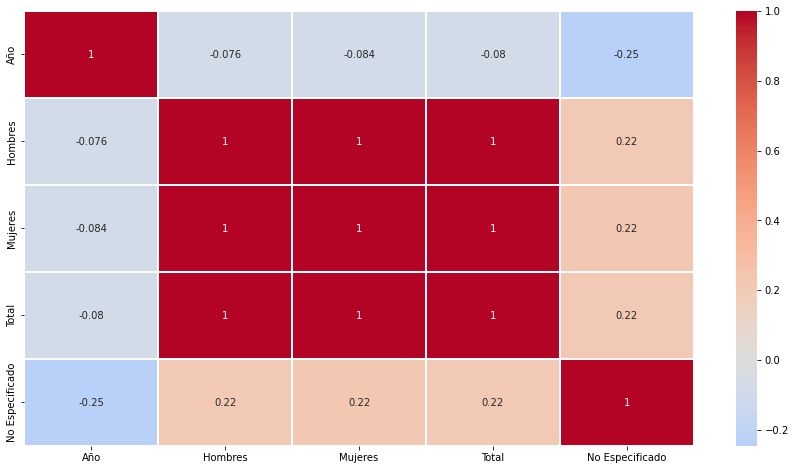

In [199]:
plt.figure(figsize=(15,8))
sns.heatmap(data=df_nacimientos[cols_num].corr(method='spearman'), vmax=1, center=0, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

#### Análisis de la matriz de correlación
Se observa una obvio y total correlación entre el número `Total` de nacimientos y los nacimientos de `Hombres` y `Mujeres`, por lo que dichos campos/columnas (`Hombres` y `Mujeres`) serán eliminados y se considerará solamente el total de nacimientos por año. Respecto a la columna `No Especificado` aunque estadísticamente tenga una correlación cercana a cero (no correlacionado) se considerará como valores outlier debido al contexto, por lo que se optará por eliminar también.

In [200]:
df_nacimientos.drop(columns=['Hombres', 'Mujeres', 'No Especificado'], inplace=True)

In [201]:
df_nacimientos.sort_values(['Estado', 'Año']).head(15)

,Estado,Total,Año
0,Aguascalientes,26583,2010
33,Aguascalientes,27427,2011
66,Aguascalientes,26933,2012
99,Aguascalientes,26434,2013
132,Aguascalientes,27080,2014
165,Aguascalientes,26486,2015
198,Aguascalientes,26388,2016
231,Aguascalientes,26955,2017
264,Aguascalientes,25938,2018
1,Baja California,63559,2010


## Visualización de los datos

Se iniciará generando diagrama de caja para cada estado. Por temas de legilibilidad, se separaran en dos gráficos aparte.

In [202]:
# The list of states is separated in two different lists.
col_list = df_nacimientos.sort_values(['Total'])['Estado'].unique()
col_list_1 = col_list[:16]
col_list_2 = col_list[16:]

# Create a new dataframe with the first list of states
df_1 = df_nacimientos[df_nacimientos['Estado'].isin(col_list_1)]

# Create a new dataframe with the last list of states
df_2 = df_nacimientos[df_nacimientos['Estado'].isin(col_list_2)]

In [203]:
fig = px.box(df_1, x="Estado", y="Total", points="all", width=1200, height=800)
fig.show()

____
De esta primera gráfica, se observa que parte de los estados más pequeños (en territorio geográfico) son los que menos nacimientos nuevos tienen por año (2010-2018). Cabe destacar que Sonora, a pesar de ser un estado con un territorio extenso, la cantidad de nacimientos por año es muy baja.
____

In [204]:
fig = px.box(df_2, x="Estado", y="Total", points="all", width=1200, height=800)
fig.show()

En esta segunda gráfica se pueden observar diferente particularidades:
- Se podría considerar a **México (Estado)** como un *"outlier"*, ya que la cantidad de nacimientos está muy por encima de los demás estados.
- El estado de **Nuevo León** es el que más *constante/estacionario* es de todo el país, ya que la cantidad de nacimientos en el período estudiado difiere muy poco entre años. Seguido de Aguascalientes, Baja California y Baja California Sur.
- Jalisco, *que es el estado de interés para este problema*, no tiene un comportamiento estacionario del todo, pero tampoco tiene variaciones tan marcadas como otros estados, por ejemplo México, Veracruz, Ciudad de México, Chiapas y San Luis Potosí.
____

Ahora, se procederá a comprar el valor promedio anual de todos los estados, para ver qué estados tienen una tendencia promedio similar a la del estado de Jalisco.
____


In [205]:
# Grouping by state
df_grouped_state = df_nacimientos.groupby(by='Estado')

# Calculating the mean value by state and sort the values in descending order
total_average_state = df_grouped_state['Total'].mean()
total_average_state = total_average_state.sort_values(ascending=False)

In [206]:
x = total_average_state.index
y = total_average_state
fig = go.Figure(data=[go.Bar(x=x, y=y,
                textposition='auto')])
fig.update_layout(title_text='Promedio anual de nacimientos por estado')
fig.show()

Con esta gráfica, se vuelve a corroborar la hipótesis de que el estado de México es un outlier. Igual mente, se peude observar que los estados de Jalisco, Veracruz y Chiapas tiene una tendencia media similar. Aunque se sabe (de la gráfica anterior) que los datos de Veracruz y Chiapas no son estacionarios.

Se procederá a graficar la serie de tiempo para los 3 estados mencionados anteriormente.

In [207]:
# The focus states are filtered
df_nacimientos_jalisco = df_nacimientos[df_nacimientos['Estado'] == 'Jalisco'].drop(columns='Estado')
df_nacimientos_veracruz = df_nacimientos[df_nacimientos['Estado'].str.contains('Veracruz')].drop(columns='Estado')
df_nacimientos_chiapas = df_nacimientos[df_nacimientos['Estado'] == 'Chiapas'].drop(columns='Estado')

In [208]:
x = df_nacimientos_jalisco['Año']
y = df_nacimientos_jalisco['Total']

marker_style = dict(
            color='LightSkyBlue',
            size=20,
            line=dict(color='MediumPurple', width=2)
)

fig = go.Figure([go.Scatter(mode="markers", x=x, y=y, marker=marker_style)])

fig.update_layout(
    title="Jalisco",
    xaxis_title="Año",
    yaxis_title="Nacimientos",
)

fig.show()

In [209]:
x = df_nacimientos_veracruz['Año']
y = df_nacimientos_veracruz['Total']

fig = go.Figure([go.Scatter(mode="markers", x=x, y=y, marker=marker_style)])

fig.update_layout(
    title="Veracruz",
    xaxis_title="Año",
    yaxis_title="Nacimientos",
)

fig.show()

In [210]:
x = df_nacimientos_chiapas['Año']
y = df_nacimientos_chiapas['Total']

fig = go.Figure([go.Scatter(mode="markers", x=x, y=y, marker=marker_style)])

fig.update_layout(
    title="Chiapas",
    xaxis_title="Año",
    yaxis_title="Nacimientos",
)

fig.show()

#### De las gráficas anteriores, se puede ver que los 3 estados tienen un comportamiento ligeramente parecido, y una tendencia a disminuir la cantidad de nacimientos por año. Sin embargo, los valores entre los que varían los estados de `Chiapas`y `Veracruz`son un mayores que los valores del estado de `Jalisco`. Esto lo pudimos corroborar con los diagramas de caja vistos anteriormente.Igualmente lo podemos ver con ayuda de la desviación estándar de cada conjunto de datos.
____

In [211]:
df_nacimientos_jalisco['Total'].std(), df_nacimientos_veracruz['Total'].std(), df_nacimientos_chiapas['Total'].std()

(6175.9708953329755, 18888.362500345138, 16762.195772365598)

#### Como se puede ver, la desviación estándar del estado de `Jalisco` es entre 2.5 y 3 veces más pequeña que los otros dos estados.

**Con base en lo anterior, se decidirá trabajar exclusivamente con los datos de Jalisco.**

## Modelo

Para el desarrollo del modelo, se iniciará de la hipótesis que la serie de tiempo considerada, es una serie de tiempo estacionaria. Se propondrá un modelo ARMA (Autoregresivo con media móvil). Dicho modelo depende de dos parámetros fundamentales:
- **p**: *Cantidad de términos autoregresivos* y
- **q**: *Cantidad de términos media móvil*.

El valor de $p$ se obtiene con ayuda de *la función parcial de autocorrelación*, mientras que el parámetro $q$ se calcula a parti de *la función de autocorrelación*. Se procede a graficar dichas funciones para la serie de tiempo considerada `df_nacimientos_jalisco`

In [212]:
df_nacimientos_jalisco.set_index('Año', inplace=True, drop=True)

In [213]:
jalisco_acf = acf(df_nacimientos_jalisco, nlags=3)
jalisco_pacf = pacf(df_nacimientos_jalisco, nlags=3, method='ols')

In [214]:
Z_VALOR = 1.96
CONFIDENCE_INTERVAL = Z_VALOR/np.sqrt(len(df_nacimientos_jalisco))

fig = go.Figure()

fig.add_trace(go.Scatter(y=jalisco_acf, mode='lines'))
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.add_hline(y=CONFIDENCE_INTERVAL, line_dash="dash", line_color="gray")
fig.add_hline(y=-CONFIDENCE_INTERVAL, line_dash="dash", line_color="gray")
# fig.add_trace(go.Scatter(y=CONFIDENCE_INTERVAL, mode='lines'))

fig.show()

In [215]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=jalisco_acf, mode='lines'))
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.add_hline(y=CONFIDENCE_INTERVAL, line_dash="dash", line_color="gray")
fig.add_hline(y=-CONFIDENCE_INTERVAL, line_dash="dash", line_color="gray")
# fig.add_trace(go.Scatter(y=CONFIDENCE_INTERVAL, mode='lines'))

fig.show()

De las gráficas anteriores, se puede obtener los respectivos valores de los parámetros $p$ y $q$ en donde las gráficas cruzan el valor superior del intervalo de confianza. En ambos casos, dicho valor es de $p=q=1$. Por lo tanto, este valor será el que se utilizará para generar el modelo.

In [216]:
df_nacimientos_jalisco.reset_index(drop=False, inplace=True)
df_nacimientos_jalisco['Año'] = pd.to_datetime(df_nacimientos_jalisco['Año'], format='%Y')
df_nacimientos_jalisco.set_index('Año', inplace=True)
model = ARIMA(df_nacimientos_jalisco['Total'], order=(1, 0, 1))
result = model.fit()
display(result.summary())

/Users/cristian/Documents/personalProyects/interview-challenge/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/cristian/Documents/personalProyects/interview-challenge/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/cristian/Documents/personalProyects/interview-challenge/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                    9
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -87.232
Date:                Tue, 11 Jan 2022   AIC                            182.463
Time:                        04:54:34   BIC                            183.252
Sample:                    01-01-2010   HQIC                           180.761
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.559e+05   7046.185     22.125      0.000    1.42e+05     1.7e+05
ar.L1          0.7630      0.552      1.381      0.167      -0.320       1.846
ma.L1          0.0990      0.685      0.144      0.885      -1.244       1.442
sigma2      1.912e+07      1.712   1.12e+07      0.000    1.91e+07    1.91e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.87   Prob(JB):                         0.67
Heteroskedasticity (H):               2.90   Skew:                            -0.41
Prob(H) (two-sided):                  0.40   Kurtosis:                         1.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.3e+23. Standard errors may be unstable.
"""

,Total
Año,
2010-01-01,161543
2011-01-01,163123
2012-01-01,161217
2013-01-01,159748
2014-01-01,158592
2015-01-01,151578
2016-01-01,148377
2017-01-01,151950
2018-01-01,146960


In [224]:
result.predict(start='2019-01-01',end='2021-01-01').rename('Predicciones Jalisco')

2019-01-01    148471.105742
2020-01-01    150231.716437
2021-01-01    151574.996315
Freq: AS-JAN, Name: Predicciones Jalisco, dtype: float64

In [218]:
model = auto_arima(df_nacimientos_jalisco['Total'])
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                    9
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -87.337
Date:                Tue, 11 Jan 2022   AIC                            180.675
Time:                        04:54:35   BIC                            181.266
Sample:                             0   HQIC                           179.398
                                  - 9                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7697.5480   2.73e+04      0.282      0.778   -4.58e+04    6.12e+04
ar.L1          0.9501      0.179      5.312      0.000       0.600       1.301
sigma2       9.92e+06     82.027   1.21e+05      0.000    9.92e+06    9.92e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.80   Prob(JB):                         0.78
Heteroskedasticity (H):               4.37   Skew:                            -0.23
Prob(H) (two-sided):                  0.26   Kurtosis:                         1.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.18e+20. Standard errors may be unstable.
"""

In [223]:
pred = pd.DataFrame(model.predict(3), index=["2019", "2020", "2021"], columns=['Predicción Jalisco'])
pred

,Predicción Jalisco
2019,147327.562462
2020,147676.791857
2021,148008.602592
